In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, get_scorer_names
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from numpy import log

In [211]:
train_set = pd.read_csv('../Comp/education-attainment-prediction-2025/CENSUS_ED_ATTN.csv')
test_set = pd.read_csv('../Comp/education-attainment-prediction-2025/Census_Test.csv')

A_HGA is our target variable

In [212]:
def clean_split_data(df, target, train_size=0.75, tune_size=0.15, random_state=21):
    X = df.drop(columns=['A_HGA', 'PEAFEVER']) 
    X[['PENATVTY', 'PEFNTVTY', 'PRDTRACE']] = X[['PENATVTY', 'PEFNTVTY', 'PRDTRACE']].astype('category')
    y = df[target].astype('category')

    # Split data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=random_state)
    
    # Split the temporary set into tuning and testing sets
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, train_size=tune_size, stratify=y_temp, random_state=random_state+28)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

# Use the function to split the movie data
X_train, X_tune, X_test, y_train, y_tune, y_test = clean_split_data(train_set, 'A_HGA')

In [213]:
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats =5, random_state=42)

In [214]:
scoring = ['accuracy', 'recall_macro', 'balanced_accuracy', 'f1_macro']
#only go to 5, because everything after is diminishing returns
param={"max_depth" : [1,2,3,4,5,6,7,8,9,10],
           }

In [215]:
cl= DecisionTreeClassifier(random_state=1000)

search = GridSearchCV(cl, param, scoring=scoring, n_jobs=1, cv=kf, refit='balanced_accuracy', return_train_score=True)

In [216]:
model = search.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=1000)


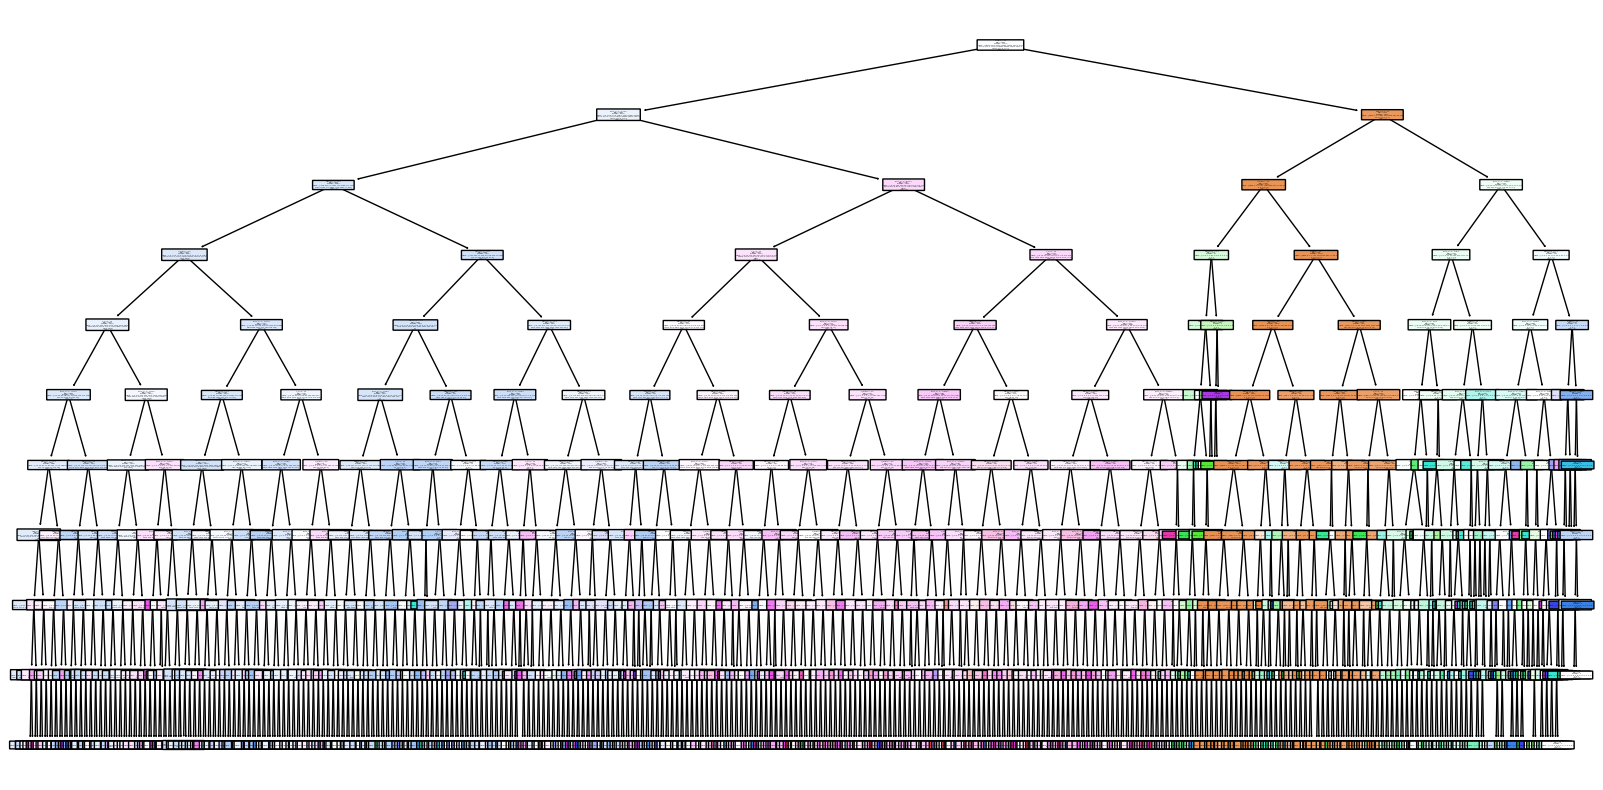

In [217]:
best= model.best_estimator_
print(best)

plt.figure(figsize=(20,10))
plot_tree(best, feature_names=X_train.columns, class_names=[str(label) for label in y_train.unique()], filled=True, rounded=True)
plt.show()

   depth  accuracy    recall   bal_acc        f1  accuracySD  recallSD  \
0      1  0.425507  0.117404  0.117404  0.079642    0.000239  0.000064   
1      2  0.464537  0.140875  0.140875  0.115529    0.001867  0.001124   
2      3  0.464819  0.141526  0.141526  0.117632    0.001915  0.001293   
3      4  0.464806  0.141339  0.141339  0.117347    0.001923  0.001316   
4      5  0.466068  0.142545  0.142545  0.120691    0.002226  0.001255   
5      6  0.470604  0.144911  0.144911  0.122997    0.002413  0.001316   
6      7  0.471697  0.145609  0.145609  0.125045    0.002343  0.001483   
7      8  0.474392  0.149602  0.149602  0.133265    0.002670  0.002023   
8      9  0.474837  0.157107  0.157107  0.145289    0.002831  0.003904   
9     10  0.474603  0.157402  0.157402  0.145472    0.002840  0.003786   

   bal_accSD      f1SD  
0   0.000064  0.000114  
1   0.001124  0.001413  
2   0.001293  0.001769  
3   0.001316  0.001934  
4   0.001255  0.002053  
5   0.001316  0.001859  
6   0.0014

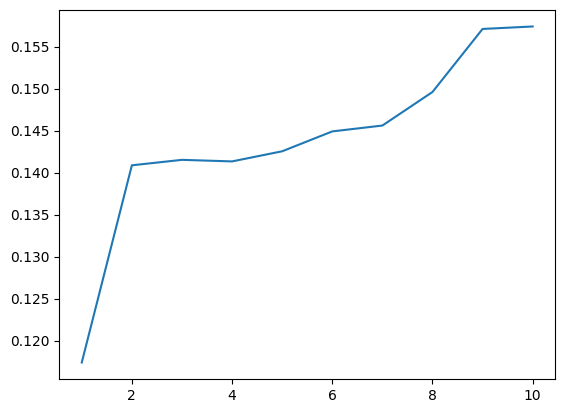

In [218]:
np.random.seed(1)
accuracy = model.cv_results_['mean_test_accuracy']
recall = model.cv_results_['mean_test_recall_macro']
bal_acc = model.cv_results_['mean_test_balanced_accuracy']
f1 = model.cv_results_['mean_test_f1_macro']

SDaccuracy = model.cv_results_['std_test_accuracy']
SDrecall = model.cv_results_['std_test_recall_macro']
SDbal_acc = model.cv_results_['std_test_balanced_accuracy']
SDf1 = model.cv_results_['std_test_f1_macro']

depth = np.unique(model.cv_results_['param_max_depth']).data

final_model = pd.DataFrame(list(zip(depth, accuracy, recall, bal_acc, f1, SDaccuracy, SDrecall, SDbal_acc, SDf1)),
               columns=['depth', 'accuracy', 'recall', 'bal_acc', 'f1', 'accuracySD', 'recallSD', 'bal_accSD', 'f1SD'])

print(final_model)
plt.plot(final_model['depth'], final_model['bal_acc'], label='Accuracy')

           importance
PARENT       0.757890
WSAL_VAL     0.102701
ERN_SRCE     0.041749
PENATVTY     0.021211
A_MARITL     0.016833
A_SEX        0.013935
PEFNTVTY     0.013767
PEINUSYR     0.011045
PEPAR1TYP    0.006782
PEHSPNON     0.004730
PRDTRACE     0.004588
PRCITSHP     0.003007
ANN_VAL      0.001762


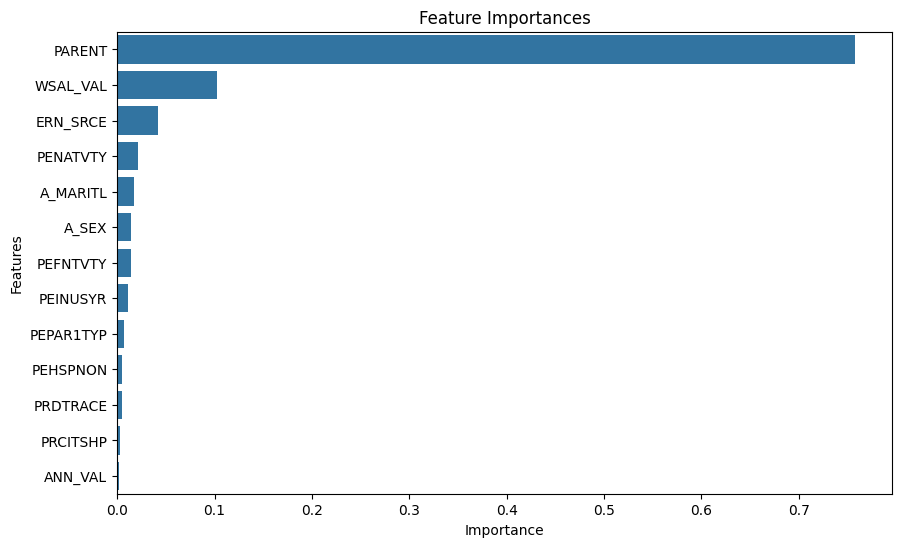

In [219]:
varimp = pd.DataFrame(best.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=varimp['importance'], y=varimp.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [220]:
tune_predictions = pd.DataFrame(model.predict(X_tune), columns=['Predicted_Label']) 

percentages = tune_predictions['Predicted_Label'].value_counts(normalize=True) * 100

# Convert to a table format
table = percentages.reset_index()
table.columns = ['Label', 'Percentage']

# Print the table
print("Percentage of Each Predicted Label:")
print(table)

Percentage of Each Predicted Label:
    Label  Percentage
0      39   50.456942
1       0   24.130053
2      43   19.894552
3      40    2.478032
4      44    1.159930
5      36    0.632689
6      32    0.228471
7      35    0.228471
8      37    0.210896
9      33    0.193322
10     42    0.175747
11     46    0.123023
12     34    0.052724
13     41    0.017575
14     31    0.017575


In [221]:
from sklearn.metrics import precision_score, classification_report

# Predict on test set using best estimator
y_pred = search.best_estimator_.predict(X_test)

# Macro precision
macro_prec = precision_score(y_test, y_pred, average='macro')
print(f"Macro Precision on Test Set: {macro_prec:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Macro Precision on Test Set: 0.2767

Classification Report:
              precision    recall  f1-score   support

           0     0.8541    0.9990    0.9208      6684
          31     0.0000    0.0000    0.0000        73
          32     0.1410    0.0696    0.0932       158
          33     0.1912    0.0435    0.0708       299
          34     0.1667    0.0036    0.0071       555
          35     0.2031    0.0187    0.0343       695
          36     0.4059    0.1045    0.1662       785
          37     0.2239    0.0169    0.0313       890
          38     0.5000    0.0022    0.0044       451
          39     0.3561    0.8183    0.4962      7067
          40     0.3184    0.0594    0.1001      3958
          41     0.1667    0.0010    0.0019      1035
          42     0.1111    0.0036    0.0071      1372
          43     0.3548    0.4396    0.3927      5155
          44     0.3642    0.0750    0.1244      2254
          45     0.1111    0.0060    0.0113       335
          46     0.23

In [222]:
# Predict the target variable for the test set
test_set = test_set.drop(columns=['PEAFEVER'])
test_predictions = model.best_estimator_.predict(test_set)

# Add predictions to the test set
test_set.index = test_set.index + 1
test_set.index.name = 'ID'
test_set['A_HGA'] = test_predictions


# Keep only the Predicted_Score and index
test_set = test_set[['A_HGA']]
print(test_set)
# Save the predictions to a CSV file
test_set.to_csv('predictions.csv', index=True, header=True)

     A_HGA
ID        
1        0
2       43
3       43
4       40
5        0
..     ...
981     39
982     39
983      0
984      0
985      0

[985 rows x 1 columns]
